# Univariate Time Series Forecasting: NARMA10
[Download Notebook](NARMA10.ipynb)
<h2 id="narma10_intro">Introduction</h2>

Time series forecasting is a crucial task in various fields, including finance, weather prediction, and signal processing. Accurate predictions of future values can enable better decision-making and planning. In recent years, machine learning techniques, such as reservoir computing, have shown promising results in addressing this challenge.

In this example, we explore time series forecasting using Nonlinear AutoRegressive Moving Average (NARMA) 10 and reservoir computing. NARMA 10 is a synthetic time series generator that mimics the behavior of real-world processes by generating nonlinear and chaotic patterns. Reservoir computing, on the other hand, is a powerful machine learning framework that leverages the dynamics of a large dynamical system, known as a reservoir, to perform tasks like time series prediction.

In thise example, we aim to demonstrate the effectiveness of reservoir computing in forecasting NARMA 10 time series data. We will implement a reservoir computing model, train it on historical NARMA 10 data, and evaluate its performance in predicting future values. By comparing the predictions with ground truth data, we can assess the accuracy and reliability of the model.

The notebook is organized as follows:

- ***Data Generation***: We generate synthetic NARMA 10 time series data to serve as our training and testing dataset.
- ***Reservoir Computing Model***: We will be utilzing QCi's photonic reservoir emulator EmuCore.
- ***Training***: We'll be using a simple linear regressor utilzing scikit-learn
- ***Evaluation***: We evaluate the performance of the trained model on the testing data using Normalized Root Mean Squared Error (NRMSE). As well as this we'll make some plots to visualize the performance across the testing and training sets.

## Reservoir Computing with EmuCore

EmuCore, developed by QCi, represents a cutting-edge electronic reservoir computing platform designed specifically for tackling complex time series forecasting tasks. EmuCore harnesses the principles of reservoir computing, a powerful machine learning paradigm inspired by the brain's dynamics, to efficiently process and predict time-dependent data. At the heart of EmuCore lies a large-scale dynamical system, referred to as the reservoir, composed of interconnected electronic components. These components exhibit rich nonlinear and chaotic dynamics, enabling EmuCore to capture and extract intricate patterns and dependencies present in time series data. The reservoir acts as a high-dimensional feature space where input signals are mapped and processed to generate accurate predictions.
In this section, we explore the capabilities of EmuCore for time series forecasting tasks. We discuss the architecture and operation principles of EmuCore, highlighting its unique features and advantages. Furthermore, we demonstrate the effectiveness of EmuCore through practical examples and experiments, showcasing its ability to accurately predict complex time series data.

Through the integration of advanced hardware design, innovative algorithms, and rigorous testing, EmuCore represents a groundbreaking solution for time series forecasting and other machine learning tasks. Its versatility, performance, and efficiency make it a valuable tool for researchers, engineers, and practitioners seeking to push the boundaries of predictive analytics and intelligent systems.

<img src="_static/figures/general_reservoir_schematics.png" alt="reservoir schematic" width="50%">

QCI's EmuCore technology is based on a time delayed scheme. However, unlike other reservoir offerings from QCi the 

<img src="_static/figures/time_delayed_reservoir_schematic.png" alt="time delayed reservoir schematic" width="50%">
<a href="https://arxiv.org/pdf/2102.09049.pdf">Photonic Reservoir Architecture and Benchmarking</a>


<h2 id="narma10_data_gen">Data Generation</h2>

Here we use widely used benchmark, namely NARMA10,

$y_{k+1} = 0.3 y_k + 0.05 y_k \sum_{𝑖=0}^{9} y_{k-i} + 1.5 u_k u_{k−9} + 0.1$

where the input 𝑢𝑘 is drawn from a uniform distribution in the interval $[0, 0.5]$.

The function below generates a NARMA10 time series and splits it into training and testing parts.

In [7]:
import numpy as np

def NARMA10(seed, train_size, test_size):    
    np.random.seed(seed)
    total_size = train_size + test_size
    utrain = 0.5 * np.random.rand(total_size, 1)
    ytrain = np.zeros((10, 1))
    for i in list(range(9, total_size - 1)):
        temp = (
            0.3 * ytrain[i]
            + 0.05 * ytrain[i] * np.sum(ytrain[i - 10 + 1 : i + 1])
            + 1.5 * utrain[i] * utrain[i - 10 + 1]
            + 0.1
        )
        ytrain = np.append(ytrain, [temp], axis=0)

    train_data = {
        "trainInput": utrain[0:train_size],
        "trainTarget": ytrain[0:train_size],
    }

    test_data = {
        "testInput": utrain[train_size:total_size],
        "testTarget": ytrain[train_size:total_size],
    }

    dataset = {"train_data": train_data, "test_data": test_data}    
    return dataset

Let us consider a time series of size 1000 with 800 samples in the training part and 200 in the testing portiong.

In [8]:
TRAIN_SIZE = 800
TEST_SIZE = 200

dataset = NARMA10(seed=0, train_size=TRAIN_SIZE, test_size=TEST_SIZE)

X_train = dataset["train_data"]["trainInput"]
y_train = dataset["train_data"]["trainTarget"].reshape((TRAIN_SIZE))

X_test = dataset["test_data"]["testInput"]
y_test = dataset["test_data"]["testTarget"].reshape((TEST_SIZE))

The target for this forecast is plotted below with the training portion in blue and the testing portion in red:

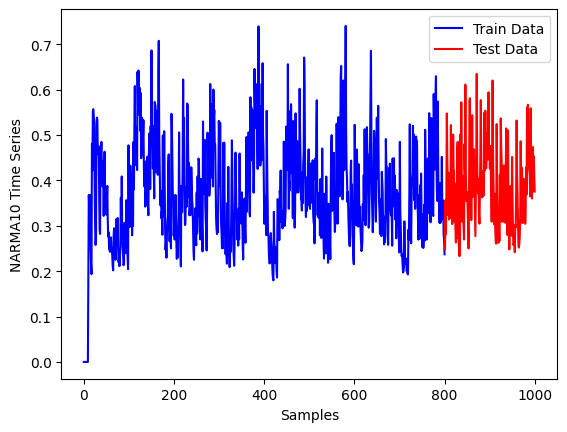

In [9]:
import matplotlib.pyplot as plt

t_train = np.linspace(0, TRAIN_SIZE, TRAIN_SIZE)
t_test = np.linspace(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE, TEST_SIZE)

plt.plot(t_train, y_train, "b")
plt.plot(t_test, y_test, "r")
plt.legend(["Train Data", "Test Data"])
plt.xlabel("Samples")
plt.ylabel("NARMA10 Time Series")
plt.show()

## Genearate Reservoir Output

After filling out some necessary details including replacing the IP_ADDR and PORT variables with our specific hardware destination we can begin interacting with the device through the client interface. Utilizing EmuCore's direct interface we first begin by acquiring the lock. This ensures that the device is not being utilized by other users or processes and ensures that no one other than the current user can manipulate the reservoir anyway. Some of the ways we can interact with the hardware include resettign the reservoir and configuring reservoir size and attributes.

In [2]:
from emucore_direct.client import EmuCoreClient
from time import time

IP_ADDR = "172.18.41.70"
PORT = "50051"
# Instantiate an EmuCore instance
ec_client = EmuCoreClient(ip_addr=IP_ADDR)
VBIAS = 0.31
GAIN = 0.72
NUM_NODES = 400
NUM_TAPS = 400
FEATURE_SCALING = 0.1
DENSITY = 1.0


# A a lock id and reset the device
lock_id, start, end = ec_client.wait_for_lock()

InactiveRpcError: acquire_lock failed due to grpc._channel._InactiveRpcError.

In [21]:
VBIAS = 0.31
GAIN = 0.72
NUM_NODES = 400
NUM_TAPS = 400
FEATURE_SCALING = 0.1
DENSITY = 1.0
# A a lock id and reset the device
#lock_id, start, end = client.wait_for_lock()
print("Reservoir reset")
ec_client.reservoir_reset(lock_id=lock_id)
print("Reservoir config")
# Configure
ec_client.rc_config(
    lock_id=lock_id,
    vbias=VBIAS,
    gain=GAIN,
    num_nodes=NUM_NODES,
    num_taps=NUM_TAPS
)

#np.random.seed(10)
#s=np.random.random(1, NUM_NODES , 0.5)
#np.random.seed(10)
#input_wgts=(2 * np.random.randint(low=0, high=2, size=(1, num_nodes)) - 1) * s.A
print("Process job")
# Push data through reservoir
resp_train, train_max_scale_val, train_wgts = ec_client.process_all_data(
    input_data=X_train,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
    #weights=input_wgts,
    #seed_val_weights = 10,
    #max_scale_val=None,
)

resp_test, test_max_scale_val, test_wgts = ec_client.process_all_data(
    input_data=X_test,
    num_nodes=NUM_NODES,
    density=DENSITY,
    feature_scaling=FEATURE_SCALING,
    lock_id=lock_id,
    #weights=input_wgts,
    #seed_val_weights = 10,
    #max_scale_val=None,
)

Reservoir reset
Reservoir config
Process job


In [22]:
ec_client.release_lock(lock_id=lock_id)

{'status': 0, 'message': 'Success'}

## Build a Linear Model

Once we have the reservoir response, we can build a simple linear regression model using the reservoir response as its input.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#resp_train = np.load("resp_train.npy")
#resp_test = np.load("resp_test.npy")

lin_model = LinearRegression()
lin_model.fit(resp_train, y_train)

y_pred_train = lin_model.predict(resp_train)
y_pred_test = lin_model.predict(resp_test)

# Calculate Mean Squared Error and R-squared
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"Train Mean Squared Error: {mse_train:.4f}")
print(f"Train R-squared: {r2_train:.2f}")

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print(f"Test Mean Squared Error: {mse_test:.4f}")
print(f"Test R-squared: {r2_test:.2f}")

Train Mean Squared Error: 0.0002
Train R-squared: 0.98
Test Mean Squared Error: 0.0004
Test R-squared: 0.95


We can look at the normalized root mean squared error (NRMSE), defined as,

$NRMSE = \sqrt{\frac{1}{m} \sum_{k=0}^{m}\frac{(\hat{y}_k - y_k)^2}{\sigma^2(y)}}$

In [24]:
def NRMSE(target, estimate):
    return np.sqrt(((estimate - target) ** 2).mean()) / np.std(target)

In [25]:
print(NRMSE(y_test, y_pred_test))

0.2247502186806958


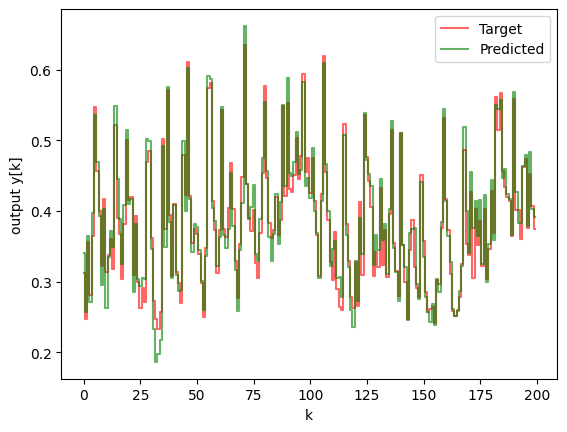

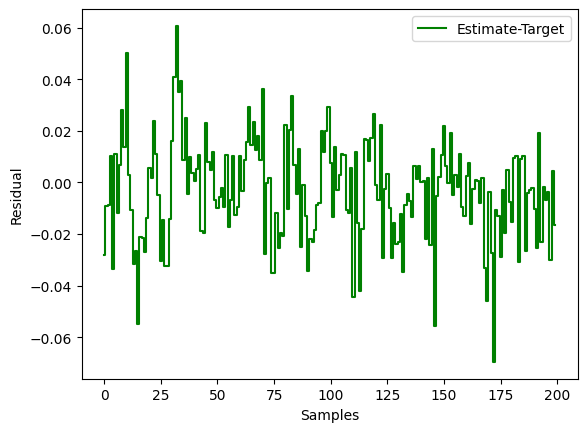

In [26]:
def StepPlotData(y1,y2,legend1="y1",legend2="y2"):
    
    plt.figure()
    assert(y1.shape[0]==y2.shape[0])
    i=np.arange(y1.shape[0])
    plt.step(i,y1,'r', where='mid', label=legend1,alpha=0.6)
    plt.legend()
    plt.step(i,y2,'g', where='mid', label=legend2,alpha=0.6)
    plt.legend()

StepPlotData(y1=y_test, y2=y_pred_test, legend1="Target", legend2="Predicted")
plt.xlabel("k")
plt.ylabel("output y[k]")
#plt.figure()
#plt.imshow(test_x, cmap="nipy_spectral")
#plt.colorbar() 

plt.figure()
plt.step(y_test-y_pred_test,'g', where='mid', label="Estimate-Target")
plt.legend()

plt.xlabel("Samples")
plt.ylabel("Residual")
plt.show()